# Clustering using `scikit-learn`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing, cluster, metrics
from sklearn.pipeline import Pipeline

from scipy.spatial.distance import cdist, pdist

from fastdtw import fastdtw

%matplotlib inline

Read in the cryptocurrencies dataset.

In [2]:
crypto = pd.read_csv('https://raw.githubusercontent.com/estimand/teaching-datasets/master/cryptocurrencies/cryptocurrencies.csv')

Convert 'date' to `datetime`.

In [3]:
crypto['date'] = pd.to_datetime(crypto['date'])

Keep only data from November 2017 onwards.

In [4]:
crypto = crypto[crypto['date'] >= '2017-11-01']

Pivot close prices.

In [5]:
crypto_close = crypto.pivot_table(values='close', index='date', columns='symbol')

In [6]:
crypto_close.head()

symbol,BCH,BTC,BTG,DASH,EOS,ETC,ETH,IOT,LTC,NEO,NXT,XLM,XMR,XRP,ZEC
date,,,,,,,,,,,,,,,
2017-11-01,529.88,6737.78,133.57,269.64,1.05,10.11,289.42,0.3644,52.83,26.87,0.05576,0.02730,85.41,0.1903,221.21
2017-11-02,562.79,7024.81,121.94,263.22,1.11,10.03,284.92,0.3661,54.19,24.62,0.06052,0.02750,83.08,0.2003,216.68
2017-11-03,626.04,7152.12,124.12,276.79,1.20,12.49,304.51,0.3927,55.98,26.67,0.05766,0.02740,87.44,0.2059,231.16
2017-11-04,614.26,7363.80,138.93,273.45,1.11,11.77,300.04,0.3685,54.83,26.44,0.05610,0.02708,87.12,0.2015,229.84
2017-11-05,625.72,7389.55,164.58,272.22,1.09,13.10,296.23,0.3506,54.60,26.24,0.05714,0.02664,86.19,0.1997,224.97


Plot (hierarchically clustered) heatmap of the correlation matrix.

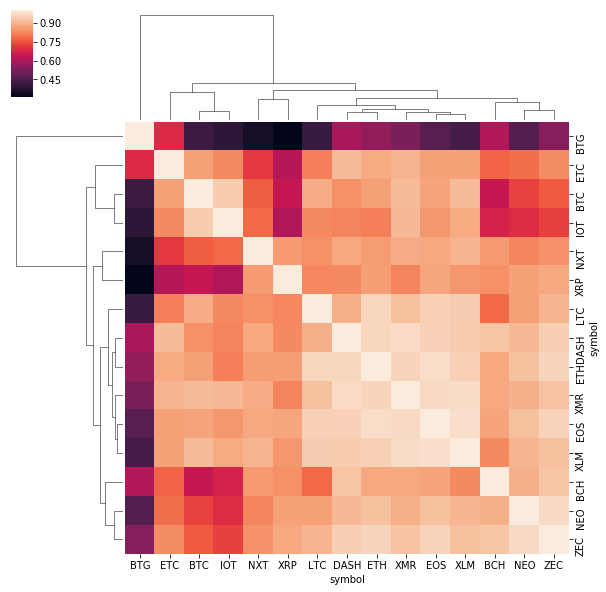

In [7]:
sns.clustermap(crypto_close.corr())

## $k$-means

Create a pipeline that scales the data and performs $k$-means clustering.

In [8]:
kmeans = Pipeline([
    ('scale', preprocessing.StandardScaler()),
    ('kmeans', cluster.KMeans())
])

Set the number of clusters to 5.

In [9]:
kmeans.set_params(
    kmeans__n_clusters=5
)

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kmeans', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))])

Fit the model and retrieve cluster assignments.

In [10]:
labels = kmeans.fit_predict(crypto_close.transpose())

## Elbow method

Scale `X`.

In [11]:
scaler = preprocessing.StandardScaler()
crypto_close_scaled = scaler.fit_transform(crypto_close.transpose())

Fit models.

In [12]:
kmeans_models = [cluster.KMeans(n_clusters=k).fit(crypto_close_scaled)
                 for k in range(1, len(crypto_close_scaled) + 1)]

Compute distance between each point and the closest centroid.

In [13]:
centroids = [model.cluster_centers_ for model in kmeans_models]
distances = [np.min(cdist(crypto_close_scaled, centroid), axis=1) for centroid in centroids]

Compute total sum of squares.

In [14]:
total_ss = np.sum(pdist(crypto_close_scaled)**2) / len(crypto_close_scaled)

Compute within-cluster sum of squares.

In [15]:
within_ss = [np.sum(d**2) for d in distances]

Compute between-cluster sum of squares (by difference).

In [16]:
between_ss = total_ss - within_ss

Plot variance explained for different values of $k$.

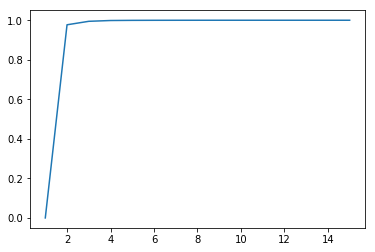

In [17]:
plt.plot(range(1, len(crypto_close_scaled) + 1), between_ss / total_ss)

Extract labels from 'best' model ($k$ = 3).

In [18]:
labels = kmeans_models[2].labels_

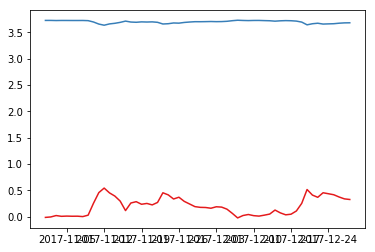

In [19]:
colors = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00"]
for i in range(np.max(labels)):
    plt.plot(crypto_close.index, crypto_close_scaled[labels == i, :].transpose(), c=colors[i])

## Custom distances

Define custom distance matrix using Dynamic Time Warping (DTW).

In [20]:
dtw_dist = np.zeros([len(crypto_close_scaled)] * 2)
for i in range(len(crypto_close_scaled)):
    for j in range(i + 1, len(crypto_close_scaled)):
        dtw_dist[i, j] = dtw_dist[j, i] = fastdtw(crypto_close_scaled[i, :], crypto_close_scaled[j, :])[0]

Perform affinity propagation clustering.

In [21]:
ap = cluster.AffinityPropagation(affinity='precomputed')
labels = ap.fit_predict(-dtw_dist)

Plot clustered time series from the 5 largest clusters.

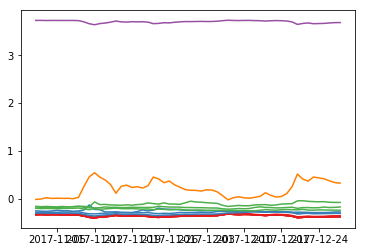

In [22]:
largest_clusters = pd.Series(labels).value_counts().index[0:5].get_values()
for i, l in enumerate(largest_clusters):
    plt.plot(crypto_close.index, crypto_close_scaled[labels == l,:].transpose(), c=colors[i])